In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from datetime import datetime
import networkx as nx

sys.path.insert(0, str(Path.cwd().parent))

from src.behavior_import.import_data import *
from src.behavior_import.extract_trials import *
from src.behavior_analysis.get_good_reversal_info import *
from src.behavior_analysis.get_choice_probs_around_good_reversals import *
from src.behavior_analysis.split_early_late_good_reversals import *
from src.behavior_analysis.get_first_leave_after_good_reversals import *
from src.behavior_visualization.plot_num_reversals import *

In [2]:
root = "../data/cohort-02/rawdata/"
subjects_data = import_data(root)

[INFO] Processed 6 subjects(s), 90 session(s).


In [3]:
subjects_trials = extract_trials(subjects_data)

[INFO] Merging multiple files for subject MY_05_L, session ses-8_date-20260114
[INFO] Merging multiple files for subject MY_05_L, session ses-9_date-20260115
[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[INFO] Merging multiple files for subject MY_05_N, session ses-2_date-20260111


In [4]:
reversal_windows = get_good_reversal_info(subjects_trials, pre=10, post=40)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[SKIP] MY_05_L reversal@401 (block 8): reward magnitudes before reversal were [4, 0, 0] across towers ['A3', 'A1', 'C3'] (expected a permutation of [4, 1, 0])


In [6]:
early, late = split_good_reversals_early_late(reversal_windows)

In [5]:
first_leave_per_subject = get_first_leave_after_good_reversals(reversal_windows)

In [9]:
def plot_first_leave_choice_bar(per_subject_counts):
    """
    Grouped bar plot per subject: fraction of reversals where first leave goes to new_best vs third.
    If include_no_leave=True, plot a third bar for no_leave.
    """
    subjects = sorted(per_subject_counts.keys())
    x = np.arange(len(subjects))
    width = 0.35

    new_frac = []
    third_frac = []
    no_leave_frac = []

    for s in subjects:
        c = per_subject_counts[s]
        denom = c["total"] if c["total"] > 0 else 1
        new_frac.append(c["new_best"] / denom)
        third_frac.append(c["third"] / denom)

    fig, ax = plt.subplots(figsize=(10, 4.5))

    ax.bar(x - width/2, new_frac, width=width, label="New Best", edgecolor="black", alpha=0.8)
    ax.bar(x + width/2, third_frac, width=width, label="Third Arm", edgecolor="black", alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(subjects, rotation=45, ha="right")
    ax.set_ylabel("Fraction of Good Reversals")
    ax.set_title("First Choice After Leaving Previous Best")
    ax.legend()

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

    return fig, ax

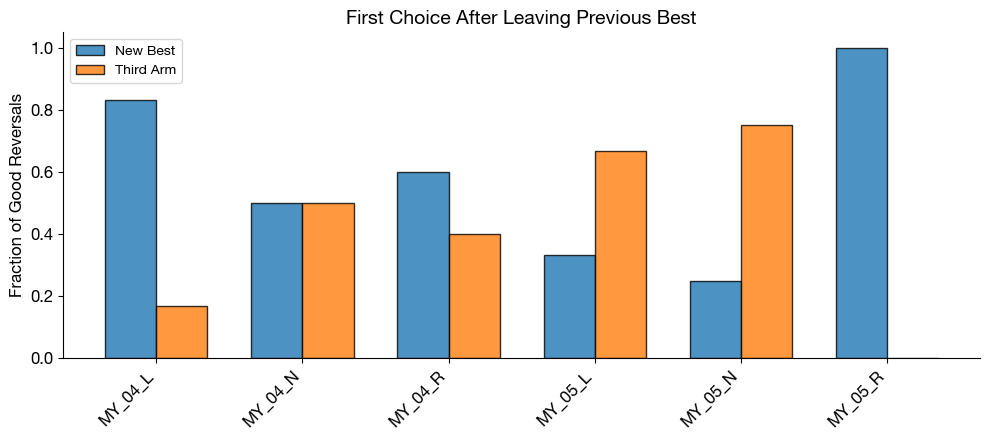

(<Figure size 1000x450 with 1 Axes>,
 <Axes: title={'center': 'First Choice After Leaving Previous Best'}, ylabel='Fraction of Good Reversals'>)

In [10]:
plot_first_leave_choice_bar(first_leave_per_subject)